In [1]:
%cd /work/pi_wqd_umass_edu

/work/pi_wqd_umass_edu


In [2]:
!git clone https://github.com/jzuhone/pyxsim
%cd pyxsim
!git checkout absorption
!pip install -e.

Cloning into 'pyxsim'...
remote: Enumerating objects: 7125, done.
remote: Counting objects: 100% (1179/1179), done.
remote: Compressing objects: 100% (437/437), done.
remote: Total 7125 (delta 806), reused 1050 (delta 721), pack-reused 5946
Receiving objects: 100% (7125/7125), 72.28 MiB | 34.70 MiB/s, done.
Resolving deltas: 100% (5273/5273), done.
/work/pi_wqd_umass_edu/pyxsim
Branch 'absorption' set up to track remote branch 'absorption' from 'origin'.
Switched to a new branch 'absorption'
Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///work/pi_wqd_umass_edu/pyxsim
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for pyxsim (pyproject.toml) ... done
  Created wheel for pyxsim: filename=pyxsim-4.4.1.dev11+g3860c4d-0.editable-cp311-cp311-linux_x86_64.whl size=426

In [1]:
!pip install soxs

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install yt

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install pyxsim

Defaulting to user installation because normal site-packages is not writeable


In [20]:
!pip install specutils

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import matplotlib
import soxs
matplotlib.rc('font', size = 18)

soxs : [WARNING  ] 2024-07-23 14:39:31,569 Setting 'soxs_data_dir' to /home/dkidwell_umass_edu/.cache/soxs for this session. Please update your configuration if you want it somewhere else.


In [3]:
import yt
import pyxsim
import re
import struct
import sys
import warnings
from io import open
import h5py
import astropy
from matplotlib.colors import LogNorm
from astropy.wcs import WCS
from astropy.io import fits
from scipy.ndimage import rotate
from astropy import wcs
import astropy.units as u
from pprint import pprint

In [4]:
print("Numpy:      {}".format(np.__version__))
print("SOXS:     {}".format(soxs.__version__))
print("YT:     {}".format(yt.__version__))
print("Pyxsim:     {}".format(pyxsim.__version__))

Numpy:      1.26.4
SOXS:     4.8.4
YT:     4.3.1
Pyxsim:     4.4.1.dev11+g3860c4d


In [5]:
%cd /work/pi_wqd_umass_edu/pyxsim

/work/pi_wqd_umass_edu/pyxsim


In [6]:
hdul = fits.open('smass-dist.fits')
data = hdul[0].data
scale_factor = 1
scaled_data = data * scale_factor
hdu = fits.PrimaryHDU(scaled_data)
hdul_new = fits.HDUList([hdu])
hdul_new.writeto('emission_map.fits', overwrite=True)

In [24]:
from yt.units import Msun, pc, kyr
#loading data for athena++
Unit_Override = {"length_unit": (1.0, "pc"),
        "mass_unit": (1.0, "Msun"),
        "time_unit": (1.0, "kyr")}
ds = yt.load("torus_rst.out2.00350.athdf", units_override=Unit_Override, unit_system="cgs",
             magnetic_normalization="lorentz_heaviside",default_species_fields='ionized')

yt : [WARNING  ] 2024-07-16 14:35:20,427 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2024-07-16 14:35:20,429 Overriding length_unit: 1.0 pc.
yt : [INFO     ] 2024-07-16 14:35:20,436 Overriding time_unit: 1.0 kyr.
yt : [INFO     ] 2024-07-16 14:35:20,438 Overriding mass_unit: 1.0 Msun.
yt : [WARNING  ] 2024-07-16 14:35:20,439 Assuming 1.0 = 1.0 K
yt : [INFO     ] 2024-07-16 14:35:20,526 Parameters: current_time              = 350.00012
yt : [INFO     ] 2024-07-16 14:35:20,528 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-07-16 14:35:20,530 Parameters: domain_left_edge          = [-5. -5. -5.]
yt : [INFO     ] 2024-07-16 14:35:20,532 Parameters: domain_right_edge         = [5. 5. 5.]
yt : [INFO     ] 2024-07-16 14:35:20,534 Parameters: cosmological_simulation   = 0


In [6]:
T_N = 10**4
def _neutral_h_density(field,data):
  nh = data['gas', 'H_nuclei_density']
  fac = np.zeros_like(nh.d)
  fac[data["gas","temperature"]< T_N] = 1.0
  return fac * nh

In [7]:
ds.add_field(("gas","H_p0_number_density"), _neutral_h_density, sampling_type="local", units="cm**-3")

In [8]:
dd = ds.all_data()

In [9]:
source_model = pyxsim.CIESourceModel("apec", 1.0, 2.0, 6000, Zmet = 3, kT_min = .025, kT_max = 20, max_density = 1.0e-18)

pyxsim : [INFO     ] 2024-07-10 15:28:15,770 kT_min = 0.025 keV
pyxsim : [INFO     ] 2024-07-10 15:28:15,771 kT_max = 20 keV


In [95]:
exp_time = (2000.0, "ks") #shorter exposure time because my computer has no memory.
area = (1500.0, "cm**2") 
redshift = 0 # its zero at first because it is local but I believe later I will be adding redshift.
dist = (8.18, "kpc")

In [11]:

inclination_angle = np.deg2rad(66)
position_angle = np.deg2rad(22)

In [12]:
# since the model is made on the Galactic plane we need to rotate it to an inclination of 66 deg and a position angle of 22 deg
from scipy.ndimage import rotate

inclination_angle = np.deg2rad(66)
position_angle = np.deg2rad(22)

#yflip2 = np.deg2rad(90)



# Define rotation matrix around z-axis (position angle)
Rtot = np.array([[np.cos(inclination_angle), np.sin(inclination_angle)*np.sin(position_angle), -np.sin(inclination_angle)*np.cos(position_angle)],
               [0, np.cos(position_angle), np.sin(position_angle)],
               [np.sin(inclination_angle), -np.cos(inclination_angle)*np.sin(position_angle), np.cos(inclination_angle)*np.cos(position_angle)]])




Rfin = np.linalg.inv(Rtot)



Thenormal_vector = Rfin[:,2]  #column
Thenorth_vector = Rfin[:,1]  #column
Theother_vector = Rfin[:,0]  
#Thenormal_vector1 = Rtest[:,2]  # Testing for other rotations
#Thenorth_vector1 = Rtest[:,1]  # Testing for other rotations



print("Rotation Matrix:")
print(Rfin)
#print(Rtest)
#print(Thenormal_vector1*-1)
#print(Thenorth_vector1*-1)
print("normal:")
print(Thenormal_vector)
print("North:")
print(Thenorth_vector)
print("---")
print ("Don't forget to mirror these values (change + and negative signs) because RA is increasing to the left and how the model is set up")
print("---")
print("Mirror Normal:")
print(Thenormal_vector*(-1))
print("Mirror North:")
print(Thenorth_vector*(-1))

print("The rotation above is not 100% accurate and we are currently still working on it so for now we are using the following vectors as our Normal and North")
print("The following vectors are from a very rough 90 degree rotation about the y-axis from the originals above")
print ("---")
L = [ 0.91354546, 0.15236623,  -0.37711965] # vector normal to cutting plane
north_vector = [ 3.74606593e-01,  -9.27183855e-01, 3.74606593e-01]
print("USE THIS NORMAL: <--")
print(L)
print("USE THIS NORTH: <--")
print(north_vector)

Rotation Matrix:
[[ 4.06736643e-01 -3.03822600e-17  9.13545458e-01]
 [ 3.42220152e-01  9.27183855e-01 -1.52366228e-01]
 [-8.47024599e-01  3.74606593e-01  3.77119649e-01]]
normal:
[ 0.91354546 -0.15236623  0.37711965]
North:
[-3.03822600e-17  9.27183855e-01  3.74606593e-01]
---
Don't forget to mirror these values (change + and negative signs) because RA is increasing to the left and how the model is set up
---
Mirror Normal:
[-0.91354546  0.15236623 -0.37711965]
Mirror North:
[ 3.03822600e-17 -9.27183855e-01 -3.74606593e-01]
The rotation above is not 100% accurate and we are currently still working on it so for now we are using the following vectors as our Normal and North
The following vectors are from a very rough 90 degree rotation about the y-axis from the originals above
---
USE THIS NORMAL: <--
[0.91354546, 0.15236623, -0.37711965]
USE THIS NORTH: <--
[0.374606593, -0.927183855, 0.374606593]


In [13]:
# This is a new routine to compute the column density map
nwidth = (128)  # number of pixels in the width of the Athena map
ndepth = (128)  # number of pixels in the depth of the Athena map
width=(float(10.0), "pc") #width of simulation cube
depth = (float(10.0), "pc") #depth of simulation cube
c = ds.arr([0.0, 0.0, 0.0], "code_length") #setting the center


L = [ 9.1354546e-01, 1.5236623e-01,  -3.7711965e-01] # vector normal to cutting plane
N = [0.374606593, -0.927183855, 0.374606593] #the North (upward facing) vector

pyxsim.make_column_density_map(ds, L, c, width, depth, nwidth, ndepth, "internal_abs_REV.h5", north_vector=N,)



Determining a cube of neutral hydrogen column density :   0%|          | 0/128 [00:00<?, ?it/s]

In [14]:
#making photons (this takes a fuck ton of time)
n_photons, n_cells = pyxsim.make_photons("my_photonstestMHD15m2Ms", dd, redshift,area, exp_time, source_model, dist = dist)

pyxsim : [INFO     ] 2024-07-10 15:34:51,569 Observing local source at distance 8.18.
pyxsim : [INFO     ] 2024-07-10 15:34:51,571 Using emission measure field '('gas', 'emission_measure')'.
pyxsim : [INFO     ] 2024-07-10 15:34:51,571 Using temperature field '('gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/118 [00:00<?, ?it/s]

Processing cells/particles :   0%|          | 0/17235968 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2024-07-10 15:47:26,086 Finished generating photons.
pyxsim : [INFO     ] 2024-07-10 15:47:26,087 Number of photons generated: 31060777
pyxsim : [INFO     ] 2024-07-10 15:47:26,088 Number of cells with photons: 2394865


In [15]:
L = [ 0.91354546, 0.15236623,  -0.37711965]
North_vector = [3.74606593e-01,  -9.27183855e-01, 3.74606593e-01]
n_events = pyxsim.project_photons("my_photonstestMHD15m2Ms", "my_photonstestMHD_REVabs_dp15m2Ms",L ,(266.42, -29),nH = 11,
                                  absorb_model = "tbabs", no_shifting = False, north_vector = North_vector, column_file = "internal_abs_REV.h5")

pyxsim : [INFO     ] 2024-07-10 15:47:26,195 Foreground galactic absorption: using the tbabs model and nH = 11.
pyxsim : [INFO     ] 2024-07-10 15:47:26,196 Internal absorption: using the tbabs model and column density map internal_abs_REV.h5.


Projecting photons from cells/particles :   0%|          | 0/2394865 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2024-07-10 15:48:26,670 Detected 4841 events.


In [16]:
#second time for no_shifting = true so there is a doppler shift
n_events = pyxsim.project_photons("my_photonstestMHD15m2Ms", "my_photonstestMHD_REVabs_dp15m2Ms",L ,(266.42, -29),nH = 11,
                                  absorb_model = "tbabs", no_shifting = True, north_vector = North_vector, column_file = "internal_abs_REV.h5")

pyxsim : [INFO     ] 2024-07-10 15:48:26,880 Foreground galactic absorption: using the tbabs model and nH = 11.
pyxsim : [INFO     ] 2024-07-10 15:48:26,881 Internal absorption: using the tbabs model and column density map internal_abs_REV.h5.


Projecting photons from cells/particles :   0%|          | 0/2394865 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2024-07-10 15:49:25,462 Detected 4974 events.


In [28]:
n_events_no_abs = pyxsim.project_photons("my_photonstestMHD15m2Ms", "no_abs_my_photonstestMHD_REVabs_dp15m2Ms",L ,(266.42, -29),nH = 11,
                                   no_shifting = True, north_vector = North_vector)

Projecting photons from cells/particles :   0%|          | 0/2394865 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2024-07-10 16:01:07,077 Detected 31060777 events.


In [29]:
events = pyxsim.EventList("no_abs_my_photonstestMHD_REVabs_dp15m2Ms.h5")
events.write_to_simput("No_REVabsorption_MHD_dp15m2Ms", overwrite = True)

soxs : [WARNING  ] 2024-07-10 16:01:20,301 Overwriting No_REVabsorption_MHD_dp15m2Ms_phlist.fits.
soxs : [INFO     ] 2024-07-10 16:01:20,608 Writing source 'No_REVabsorption_MHD_dp15m2Ms' to No_REVabsorption_MHD_dp15m2Ms_phlist.fits.


In [30]:
events = pyxsim.EventList("my_photonstestMHD_REVabs_dp15m2Ms.h5")
events.write_to_simput("REVabsorption_MHD_dp15m2Ms", overwrite = True)

soxs : [WARNING  ] 2024-07-10 16:01:21,837 Overwriting REVabsorption_MHD_dp15m2Ms_phlist.fits.
soxs : [INFO     ] 2024-07-10 16:01:21,921 Writing source 'REVabsorption_MHD_dp15m2Ms' to REVabsorption_MHD_dp15m2Ms_phlist.fits.


In [5]:
# make new instrument based on Chandra cycle 13
from soxs import get_instrument_from_registry, add_instrument_to_registry
new_chandra = get_instrument_from_registry("chandra_aciss_cy22")
new_chandra["name"] = "2chandra_aciss_sgra_cy13" # Must change the name, otherwise an error will be thrown
new_chandra["arf"] = "asgras_src.arf" # arf of cycle 13
new_chandra["rmf"] = "asgras_src.rmf" # rmf of cycle 13


name = add_instrument_to_registry(new_chandra)

In [36]:
exp_time = (230.0, "ks")
fov = (8.3)
sky_center= [266.42, -29]


In [37]:
soxs.make_point_sources_file('Source_cat_simput.fits', "ptsrc", exp_time, fov, sky_center, prng = 24, output_sources="point_source_table.dat", overwrite = True)

soxs : [INFO     ] 2024-07-16 14:53:25,906 Appending source 'ptsrc' to Source_cat_simput.fits.


In [53]:
soxs.instrument_simulator("Source_cat_simput.fits", "Power_law_evt.fits", (230.0,"ks"),"chandra_acisi_cy22", 
                          [266.42, -29], overwrite=True, ptsrc_bkgnd=False,foreground=False,instr_bkgnd=False)

soxs : [INFO     ] 2024-07-16 15:47:38,190 Making observation of source in Power_law_evt.fits.
soxs : [INFO     ] 2024-07-16 15:47:38,341 Detecting events from source ptsrc.
soxs : [INFO     ] 2024-07-16 15:47:38,343 Applying energy-dependent effective area from acisi_aimpt_cy22.arf.
soxs : [INFO     ] 2024-07-16 15:47:38,435 Pixeling events.
soxs : [INFO     ] 2024-07-16 15:47:38,437 Scattering events with a multi_image-based PSF.
soxs : [INFO     ] 2024-07-16 15:47:38,497 2798 events were detected from the source.
soxs : [INFO     ] 2024-07-16 15:47:38,498 Scattering energies with RMF acisi_aimpt_cy22.rmf.


Scattering energies :   0%|          | 0/2798 [00:00<?, ?it/s]

soxs : [INFO     ] 2024-07-16 15:47:38,700 No backgrounds will be added to this observation.
soxs : [INFO     ] 2024-07-16 15:47:38,701 Writing events to file Power_law_evt.fits.
soxs : [INFO     ] 2024-07-16 15:47:38,733 Observation complete.


In [45]:
#Simulate observing with lynx
soxs.instrument_simulator("REVabsorption_MHD_dp15m2Ms_phlist.fits._simput.fits", "REVabs_MHD_dp15m2Ms_lynx230ks_evt.fits", (230.0,"ks"),"chandra_acisi_cy22", 
                          [266.42, -29], overwrite=True, ptsrc_bkgnd=False,foreground=False,instr_bkgnd=True)
#all of these are the potential instruments I have used 
#and lynx_lxm is overall the best but may need smaller observation times
#"xrism_resolve"
#"lynx_lxm"
#"chandra_acisi_cy22"

soxs : [INFO     ] 2024-07-16 15:40:15,987 Making observation of source in REVabs_MHD_dp15m2Ms_lynx230ks_evt.fits.
soxs : [INFO     ] 2024-07-16 15:40:16,117 Detecting events from source REVabsorption_MHD_dp15m2Ms_phlist.fits..
soxs : [INFO     ] 2024-07-16 15:40:16,118 Applying energy-dependent effective area from acisi_aimpt_cy22.arf.
soxs : [INFO     ] 2024-07-16 15:40:16,128 Pixeling events.
soxs : [INFO     ] 2024-07-16 15:40:16,130 Scattering events with a multi_image-based PSF.
soxs : [INFO     ] 2024-07-16 15:40:16,190 4047 events were detected from the source.
soxs : [INFO     ] 2024-07-16 15:40:16,192 Scattering energies with RMF acisi_aimpt_cy22.rmf.


Scattering energies :   0%|          | 0/4047 [00:00<?, ?it/s]

soxs : [INFO     ] 2024-07-16 15:40:16,344 Adding background events.
soxs : [INFO     ] 2024-07-16 15:40:16,398 Adding in instrumental background.
soxs : [INFO     ] 2024-07-16 15:40:16,447 Making 304680 events from the instrumental background.
soxs : [INFO     ] 2024-07-16 15:40:16,476 Writing events to file REVabs_MHD_dp15m2Ms_lynx230ks_evt.fits.
soxs : [INFO     ] 2024-07-16 15:40:16,619 Observation complete.


In [46]:
soxs.instrument_simulator("No_REVabsorption_MHD_dp15m2Ms_simput.fits", "No_REVabs_MHD_dp15m2Ms_lynx230ks_evt.fits", (230.0,"ks"),"chandra_acisi_cy22", 
                          [266.42, -29], overwrite=True, ptsrc_bkgnd=False,foreground=False,instr_bkgnd=True)

soxs : [INFO     ] 2024-07-16 15:40:25,322 Making observation of source in No_REVabs_MHD_dp15m2Ms_lynx230ks_evt.fits.
soxs : [INFO     ] 2024-07-16 15:40:26,625 Detecting events from source No_REVabsorption_MHD_dp15m2Ms.
soxs : [INFO     ] 2024-07-16 15:40:26,626 Applying energy-dependent effective area from acisi_aimpt_cy22.arf.
soxs : [INFO     ] 2024-07-16 15:40:28,717 Pixeling events.
soxs : [INFO     ] 2024-07-16 15:40:28,843 Scattering events with a multi_image-based PSF.
soxs : [INFO     ] 2024-07-16 15:40:29,028 411844 events were detected from the source.
soxs : [INFO     ] 2024-07-16 15:40:29,053 Scattering energies with RMF acisi_aimpt_cy22.rmf.


Scattering energies :   0%|          | 0/411844 [00:00<?, ?it/s]

soxs : [INFO     ] 2024-07-16 15:40:29,226 Adding background events.
soxs : [INFO     ] 2024-07-16 15:40:29,281 Adding in instrumental background.
soxs : [INFO     ] 2024-07-16 15:40:29,331 Making 304869 events from the instrumental background.
soxs : [INFO     ] 2024-07-16 15:40:29,362 Writing events to file No_REVabs_MHD_dp15m2Ms_lynx230ks_evt.fits.
soxs : [INFO     ] 2024-07-16 15:40:29,654 Observation complete.


In [47]:
soxs.write_image("REVabs_MHD_dp15m2Ms_lynx230ks_evt.fits","REVabs_MHD_dp15m2Ms_lynx230ks_img.fits", overwrite=True)

In [48]:
soxs.write_image("No_REVabs_MHD_dp15m2Ms_lynx230ks_evt.fits","No_REVabs_MHD_dp15m2Ms_lynx230ks_img.fits", overwrite=True)

In [55]:
soxs.write_image('Power_law_evt.fits', 'power_law_img.fits', overwrite = True)

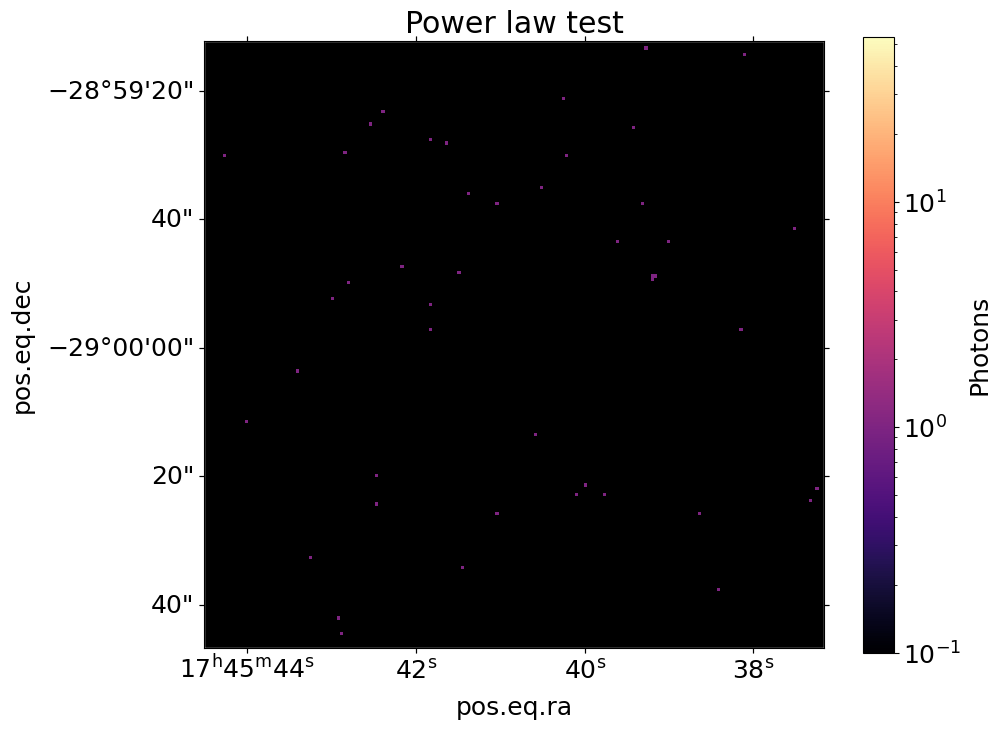

In [56]:
width = 400
with fits.open("power_law_img.fits")as f:
  hdu = f["IMAGE"]
  wcs = WCS(hdu.header)
  center = wcs.wcs.crpix
  fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=wcs))
  p = ax.imshow(hdu.data, norm=LogNorm(vmin=0.1),cmap='magma')
  ax.set_ylim(center[1]-0.24*width, center[1]+0.24*width)
  ax.set_xlim(center[0]-0.25*width, center[0]+0.24*width)
  ax.set_facecolor('black')
  ax.xaxis.label.set_color('white')
  ax.set_title("Power law test")
  fig.colorbar(p,label = 'Photons',shrink=0.80)

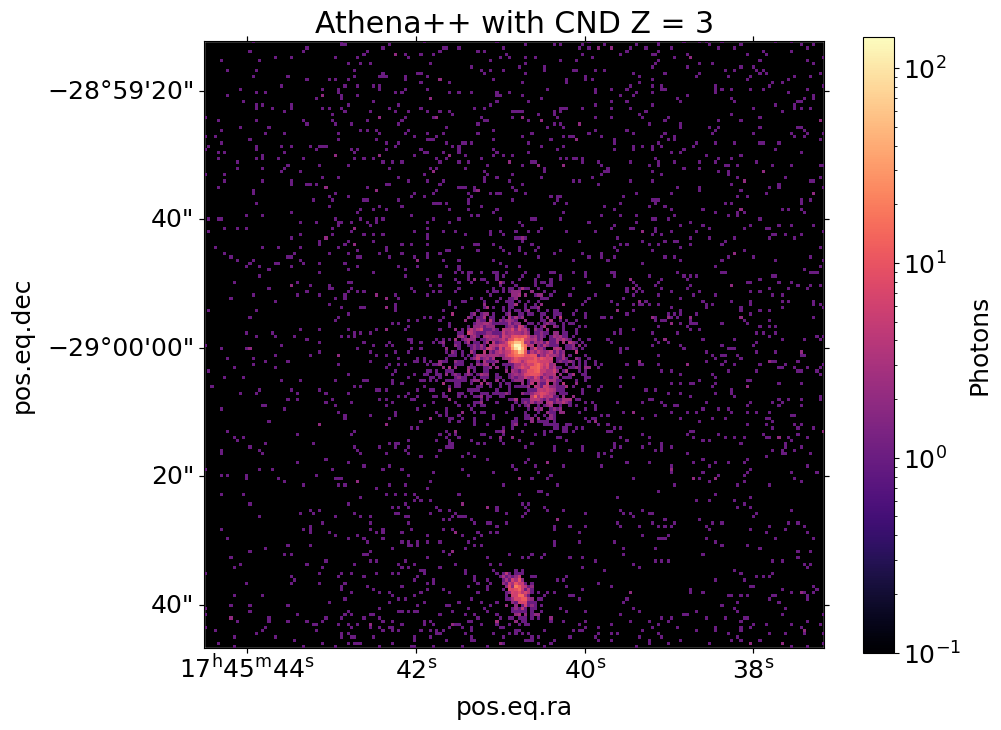

In [49]:
#printing image
width = 400
with fits.open("REVabs_MHD_dp15m2Ms_lynx230ks_img.fits")as f:
  hdu = f["IMAGE"]
  wcs = WCS(hdu.header)
  center = wcs.wcs.crpix
  fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=wcs))
  p = ax.imshow(hdu.data, norm=LogNorm(vmin=0.1),cmap='magma')
  ax.set_ylim(center[1]-0.24*width, center[1]+0.24*width)
  ax.set_xlim(center[0]-0.25*width, center[0]+0.24*width)
  ax.set_facecolor('black')
  ax.xaxis.label.set_color('white')
  ax.set_title("Athena++ with CND Z = 3")
  fig.colorbar(p,label = 'Photons',shrink=0.80)

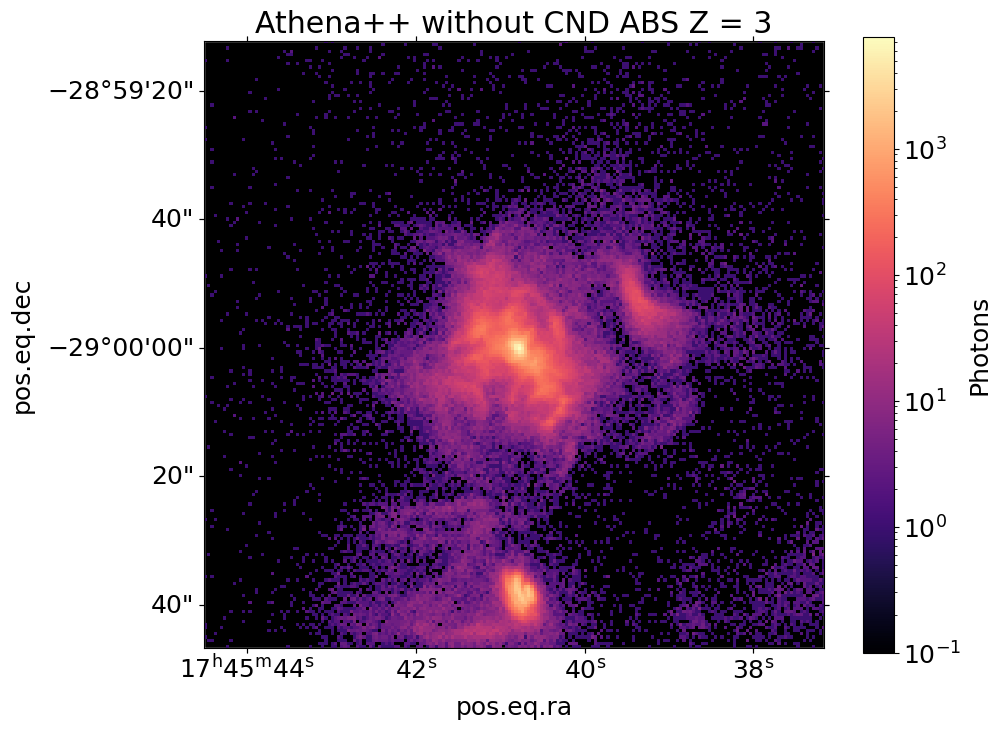

In [50]:
#printing image
width = 400
with fits.open("No_REVabs_MHD_dp15m2Ms_lynx230ks_img.fits")as f:
  hdu = f["IMAGE"]
  wcs = WCS(hdu.header)
  center = wcs.wcs.crpix
  fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=wcs))
  p = ax.imshow(hdu.data, norm=LogNorm(vmin=0.1),cmap='magma')
  ax.set_ylim(center[1]-0.24*width, center[1]+0.24*width)
  ax.set_xlim(center[0]-0.25*width, center[0]+0.24*width)
  ax.set_facecolor('black')
  ax.xaxis.label.set_color('white')
  ax.set_title("Athena++ without CND ABS Z = 3")
  fig.colorbar(p,label = 'Photons',shrink=0.80)

yt : [INFO     ] 2024-07-10 15:50:16,054 xlim = -3.500000 3.500000
yt : [INFO     ] 2024-07-10 15:50:16,055 ylim = -3.500000 3.500000
yt : [INFO     ] 2024-07-10 15:50:16,057 zlim = -5.000000 5.000000
yt : [INFO     ] 2024-07-10 15:50:16,081 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800



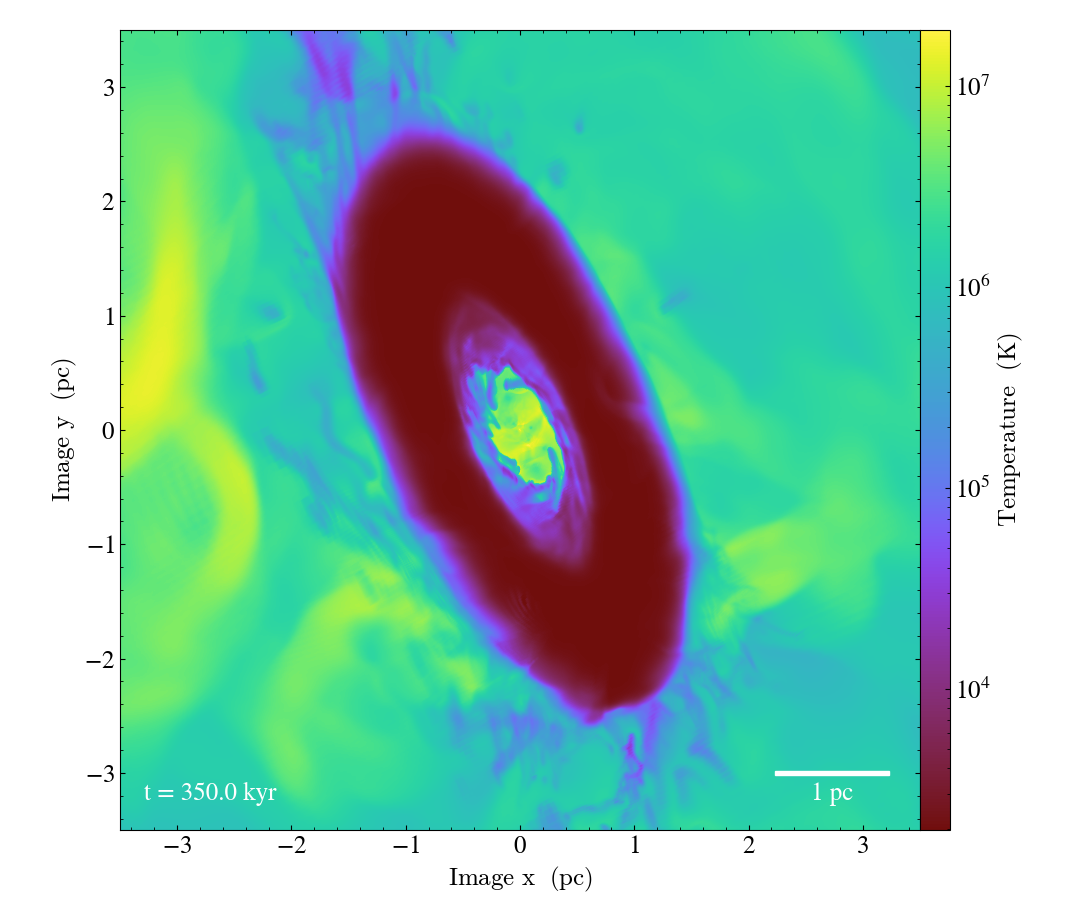

In [27]:
prj = yt.ProjectionPlot(
    ds, L, ('gas', 'temperature'), weight_field=("gas", "density"), width=(7, "pc"),north_vector=N, method = ("integrate")
)

prj.set_width((7, "pc"))
prj.set_axes_unit("pc")
prj.annotate_scale()
prj.annotate_timestamp()

prj.show()

In [6]:
absfile = 'REVabs_MHD_dp15m2Ms_lynx230ks_img.fits'
noabsfile = 'No_REVabs_MHD_dp15m2Ms_lynx230ks_img.fits'
hdul = fits.open(absfile)
hdul2 = fits.open(noabsfile)
absd = hdul[0].data
noabsd = hdul2[0].data
vals = (noabsd - absd) / noabsd
fits.writeto('difference_map_img.fits', vals, overwrite = True)

/tmp/ipykernel_1889847/1331663590.py:7: RuntimeWarning: divide by zero encountered in divide
  vals = (noabsd - absd) / noabsd
/tmp/ipykernel_1889847/1331663590.py:7: RuntimeWarning: invalid value encountered in divide
  vals = (noabsd - absd) / noabsd


In [21]:
hdu_list = fits.open("difference_map_img.fits")
hdu_list.info()

Filename: difference_map_img.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (4880, 4880)   float64   


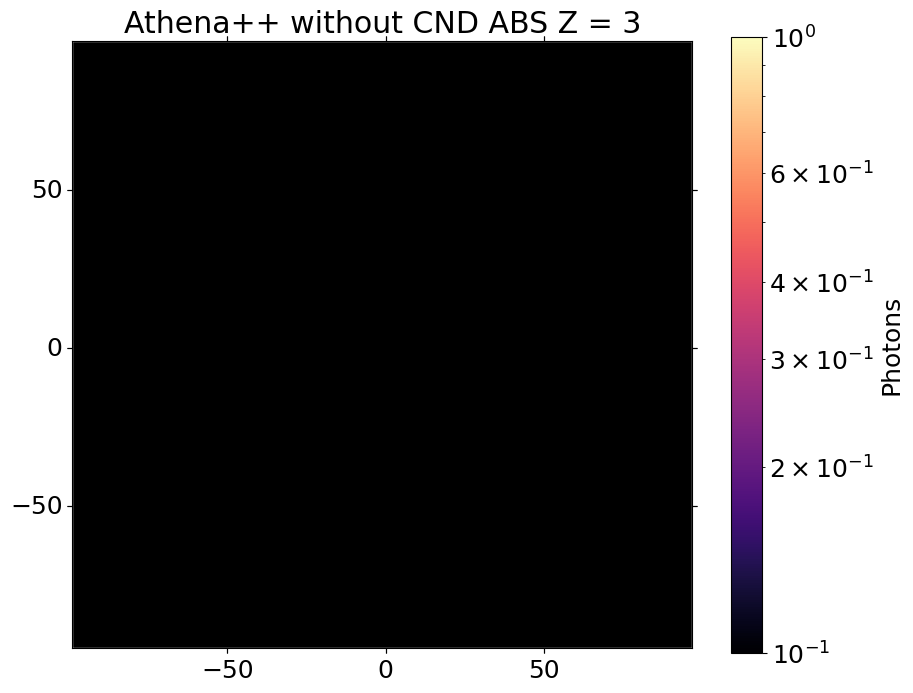

In [8]:
#printing image
width = 400
with fits.open("difference_map_img.fits")as f:
  hdu = f["PRIMARY"]
  wcs = WCS(hdu.header)
  center = wcs.wcs.crpix
  fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=wcs))
  p = ax.imshow(hdu.data, norm=LogNorm(vmin=0.1),cmap='magma')
  ax.set_ylim(center[1]-0.24*width, center[1]+0.24*width)
  ax.set_xlim(center[0]-0.25*width, center[0]+0.24*width)
  ax.set_facecolor('black')
  ax.xaxis.label.set_color('white')
  ax.set_title("Athena++ without CND ABS Z = 3")
  fig.colorbar(p,label = 'Photons',shrink=0.80)

In [30]:
ra0, dec0 = 266.42, -29 # center coords of image, from event file (updated to proper degrees)
nx = 255 # size of image, got from file (remember to update if you use a cut version)
#x=255 y=130 what is that in pixel space
dx = 0.5*u.arcsec # pixel size, you told me

In [31]:
with fits.open('smass-dist.fits') as hdu2:
    data2 = hdu2[0].data
    head2 = hdu2[0].header
    flux = data2*5.5e-9*(0.5**2) # applying the conversion so we have the file in flux
    filename = 'smass-dist.fits'
    output_filename = filename.split('/')[-1]
    fits.writeto('flux_'+ output_filename, flux, header=head2, overwrite=True)

In [32]:
f = "flux_smass-dist.fits"

fd = fits.getdata(f)
head = fits.getheader(f)


"""    #remove left side
fd1 = np.delete(fd, slice(0,150), 1)
    #remove right side (remember the right limit has already been reduced)
fd2 = np.delete(fd1,slice(312,462),1)
    #remove bottom
fd3 = np.delete(fd2,slice(0,150),0)
    #remove top(remember the top limit has already been reduced)
fd_done = np.delete(fd3,slice(312,462),0) """
fits.writeto("flux_NCcut.fits",fd, header= head, overwrite=True)
print("finished")

finished


In [33]:
w=WCS(naxis=2)
w.wcs.cunit = ["deg"]*2
w.wcs.crval = [ra0, dec0] # center of image in RA, Dec
w.wcs.crpix = [(nx+1),.5*(nx+1)] # center of image in pixel space
w.wcs.cdelt = [-dx.to_value("deg"), dx.to_value("deg")]
w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
wheader = w.to_header()
pprint(wheader)

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                256.0 / Pixel coordinate of reference point            
CRPIX2  =                128.0 / Pixel coordinate of reference point            
CDELT1  = -0.00013888888888889 / [deg] Coordinate increment at reference point  
CDELT2  =  0.00013888888888889 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---TAN'           / Right ascension, gnomonic projection           
CTYPE2  = 'DEC--TAN'           / Declination, gnomonic projection               
CRVAL1  =               266.42 / [deg] Coordinate value at reference point      
CRVAL2  =                -29.0 / [deg] Coordinate value at reference point      
LONPOLE =                180.0 / [deg] Native longitude of celestial pole       
LATPOLE =                -29

In [34]:
with fits.open("flux_NCcut.fits") as f:
    data = f[0].data.copy()
    tot_flux = data.sum()
    header = f[0].header.copy()
    header.update(wheader)
    hdu = fits.PrimaryHDU(data, header=header)
    hdu.writeto("flux_NCcut_sky.fits", overwrite=True)

In [35]:
agen = soxs.ApecGenerator(3.0, 9.0, 1000) #Changing this (to fewer bins or a smaller range (so far 3-10 has worked, will greatly reduce the photons generated 
spec = agen.get_spectrum(0.8, 1.0, 0.0, 1.0) # I normalized this to 1 at first (kT, abund, redshift, norm)
spec.rescale_flux(tot_flux, emin=4, emax=9) # now rescale by the flux from the file
spec.apply_foreground_absorption(11, model="tbabs") # n_H is The hydrogen column in units of 10**22 atoms/cm**2 we set 11

In [36]:
bkg_src = soxs.SimputSpectrum.from_spectrum("NSCcut", spec, ra0, dec0, imhdu="flux_NCcut_sky.fits")

In [37]:
sim_cat = soxs.SimputCatalog.from_source(
    "NSCcut_simput.fits", bkg_src, overwrite=True
)

soxs : [INFO     ] 2024-06-27 17:10:30,795 Appending source 'NSCcut' to NSCcut_simput.fits.


In [38]:
soxs.instrument_simulator("NSCcut_simput.fits", "NSC13cut_230ks_evt.fits", (230, "ks"),
                          "chandra_aciss_cy22", [266.42, -29], instr_bkgnd=False,
                          foreground=False, ptsrc_bkgnd=False, overwrite=True)

soxs : [INFO     ] 2024-06-27 17:10:35,929 Making observation of source in NSC13cut_230ks_evt.fits.
soxs : [INFO     ] 2024-06-27 17:10:36,057 Detecting events from source NSCcut.
soxs : [INFO     ] 2024-06-27 17:10:36,058 Applying energy-dependent effective area from aciss_aimpt_cy22.arf.
soxs : [INFO     ] 2024-06-27 17:10:51,810 Pixeling events.
soxs : [INFO     ] 2024-06-27 17:11:02,232 Scattering events with a multi_image-based PSF.
soxs : [INFO     ] 2024-06-27 17:11:19,080 44470207 events were detected from the source.
soxs : [INFO     ] 2024-06-27 17:11:22,547 Scattering energies with RMF aciss_aimpt_cy22.rmf.


Scattering energies :   0%|          | 0/44470207 [00:00<?, ?it/s]

soxs : [INFO     ] 2024-06-27 17:11:33,869 No backgrounds will be added to this observation.
soxs : [INFO     ] 2024-06-27 17:11:33,870 Writing events to file NSC13cut_230ks_evt.fits.
soxs : [INFO     ] 2024-06-27 17:11:44,231 Observation complete.


In [39]:
soxs.write_image("NSC13cut_230ks_evt.fits", "NSC13cut_230ks_img.fits", overwrite=True)

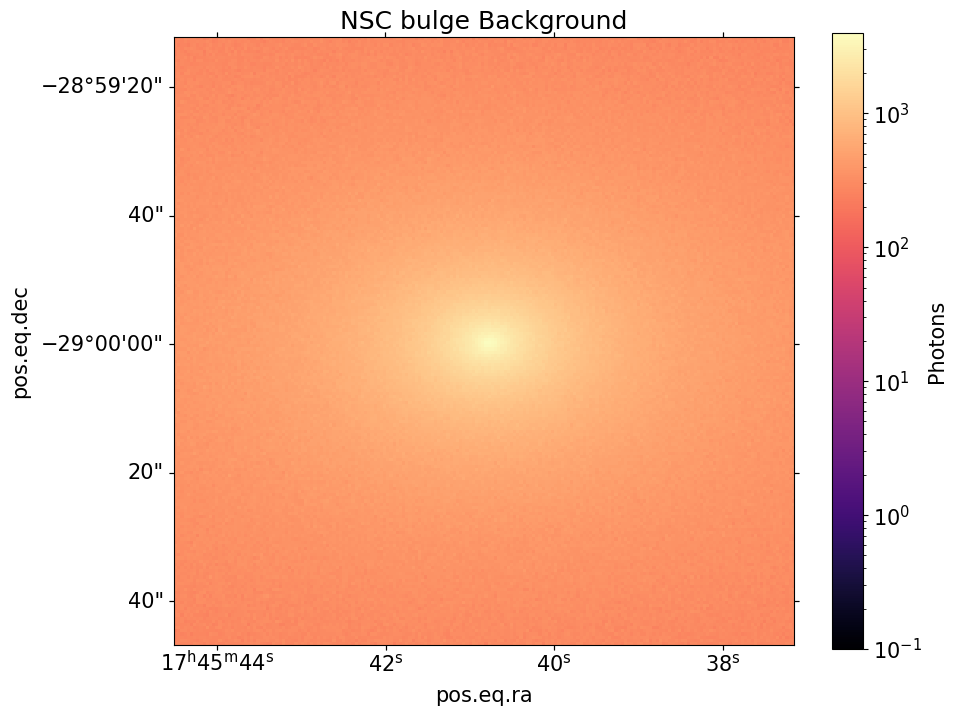

In [40]:
from astropy.io import fits
width = 400
with fits.open("NSC13cut_230ks_img.fits") as f:
    hdu = f["IMAGE"] # grab the image 
    wcs = WCS(hdu.header) # grabs the coordinate system
    center = wcs.wcs.crpix # t center pixel coordinates of the image
    fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=wcs))
    # Create the image with a logscale
    p = ax.imshow(hdu.data, norm=LogNorm(vmin=0.1),cmap='magma')
    plt.rcParams['font.size'] = '15'
    # Sets the limits of the plot

    ax.set_xlim(center[0]-0.25*width, center[0]+0.24*width) 
    ax.set_ylim(center[1]-0.24*width, center[1]+0.24*width)
    #ax.set_title('Lynx With Doppler 230ks')
# Zeros get set to a white color
    ax.set_facecolor('black')
    #ax.tick_params(axis='x', colors='white')
    #ax.tick_params(axis='y', colors='white')
    ax.xaxis.label.set_color('white')
    #ax.margins(x=-0.45, y=-0.25) 
    ax.set_title("NSC bulge Background")

 

    
    fig.colorbar(p,label = 'Photons',shrink=0.80)

In [41]:
soxs.merge_event_files(["REVabs_MHD_dp15m2Ms_lynx230ks_evt.fits", "NSC13cut_230ks_evt.fits"], "totchandra_230kscut_evt.fits", overwrite=True)

In [42]:
soxs.write_image("totchandra_230kscut_evt.fits", "totchandra_230kscut_img.fits", overwrite=True)

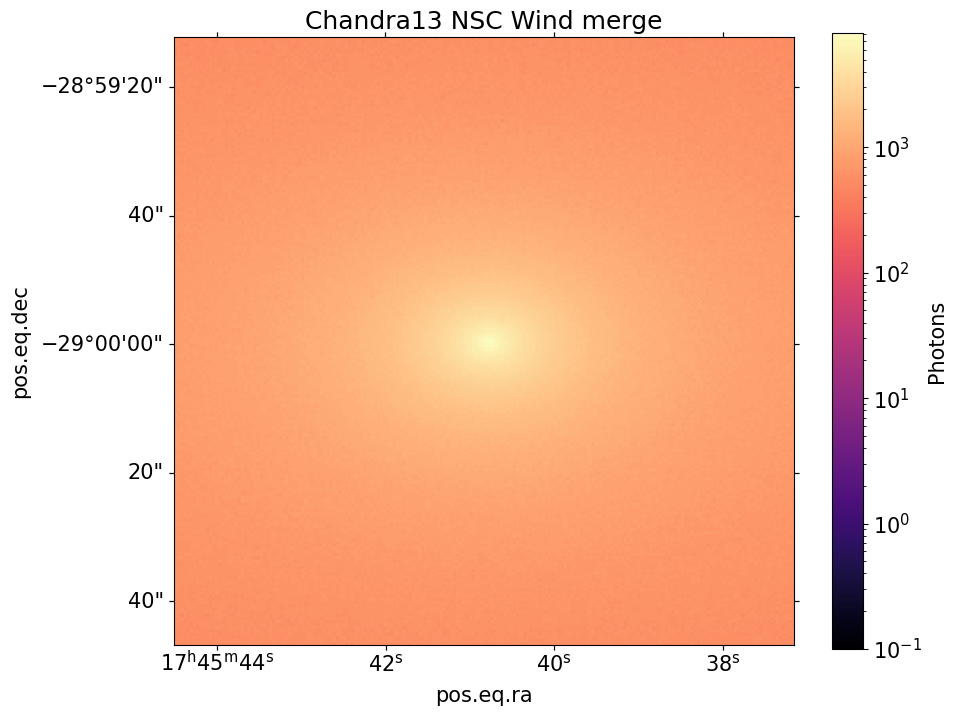

In [43]:
from astropy.io import fits
width = 400
with fits.open("totchandra_230kscut_img.fits") as f:
    hdu = f["IMAGE"] # grab the image 
    wcs = WCS(hdu.header) # grabs the coordinate system
    center = wcs.wcs.crpix # t center pixel coordinates of the image
    fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=wcs))
    # Create the image with a logscale
    p = ax.imshow(hdu.data, norm=LogNorm(vmin=0.1),cmap='magma')
    plt.rcParams['font.size'] = '15'
    # Sets the limits of the plot

    ax.set_xlim(center[0]-0.25*width, center[0]+0.24*width) 
    ax.set_ylim(center[1]-0.24*width, center[1]+0.24*width)
    #ax.set_title('Lynx With Doppler 230ks')
# Zeros get set to a white color
    ax.set_facecolor('black')
    #ax.tick_params(axis='x', colors='white')
    #ax.tick_params(axis='y', colors='white')
    ax.xaxis.label.set_color('white')
    #ax.margins(x=-0.45, y=-0.25) 
    ax.set_title("Chandra13 NSC Wind merge")

 

    
    fig.colorbar(p,label = 'Photons',shrink=0.80)